In [1]:
import tensorflow as tf

gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
    # Currently, memory growth needs to be the same across GPUs
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        logical_gpus = tf.config.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
    # Memory growth must be set before GPUs have been initialized
        print(e)

1 Physical GPUs, 1 Logical GPUs


In [2]:
import SimpleITK as sitk
import os
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers
from keras.models import Model
from keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate, Dropout, BatchNormalization
from tensorflow.keras import backend as K
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import ModelCheckpoint, CSVLogger
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.metrics import MeanIoU
from tensorflow.keras.models import load_model


In [3]:
# adc_folder_path = '/content/drive/My Drive/MSc Project/BONBID2023_Train/1ADC_ss'
adc_folder_path = 'BONBID2023_Train/1ADC_ss'
adc_files = [os.path.join(adc_folder_path, f) for f in os.listdir(adc_folder_path) if f.endswith('.mha')]
adc_files = sorted(adc_files)

In [4]:
# zadc_folder_path = '/content/drive/My Drive/MSc Project/BONBID2023_Train/2Z_ADC'
zadc_folder_path = 'BONBID2023_Train/2Z_ADC'
zadc_files = [os.path.join(zadc_folder_path, f) for f in os.listdir(zadc_folder_path) if f.endswith('.mha')]
zadc_files = sorted(zadc_files)

In [5]:
# label_folder_path = '/content/drive/My Drive/MSc Project/BONBID2023_Train/3LABEL'
label_folder_path = 'BONBID2023_Train/3LABEL'
label_files = [os.path.join(label_folder_path, f) for f in os.listdir(label_folder_path) if f.endswith('.mha')]
label_files = sorted(label_files)

# **Read and display data**

Read and display ADC data

In [6]:
adc_data = []
adc_stik_data = []
for file in adc_files:
    image = sitk.ReadImage(file)
    adc_stik_data.append(image)
    array = sitk.GetArrayFromImage(image)
    adc_data.append(array)

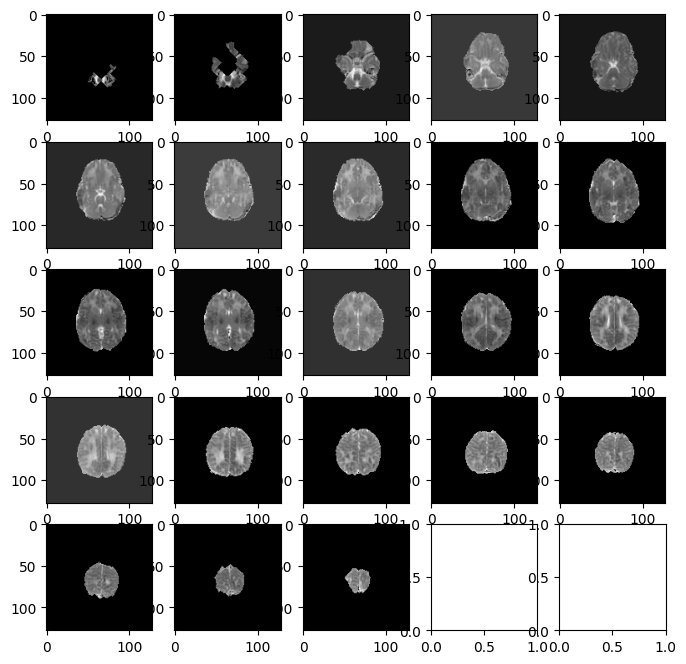

In [7]:
fig, axes = plt.subplots(5,5, figsize=(8,8))

for i,ax in enumerate(axes.flat):
    if i < adc_data[0].shape[0]:
        ax.imshow(adc_data[0][i], cmap='gray')

Read and display Zadc data

In [8]:
zadc_data = []
for file in zadc_files:
    image = sitk.ReadImage(file)
    array = sitk.GetArrayFromImage(image)
    zadc_data.append(array)

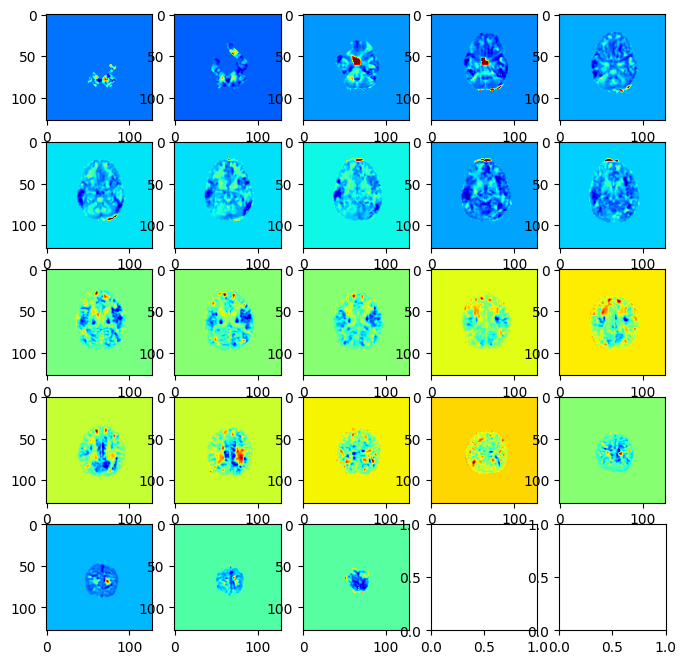

In [9]:
fig, axes = plt.subplots(5,5, figsize=(8,8))

for i,ax in enumerate(axes.flat):
    if i < zadc_data[0].shape[0]:
        ax.imshow(zadc_data[0][i], cmap="jet")

Read and display label data

In [10]:
label_data = []
for file in label_files:
    image = sitk.ReadImage(file)
    array = sitk.GetArrayFromImage(image)
    label_data.append(array)

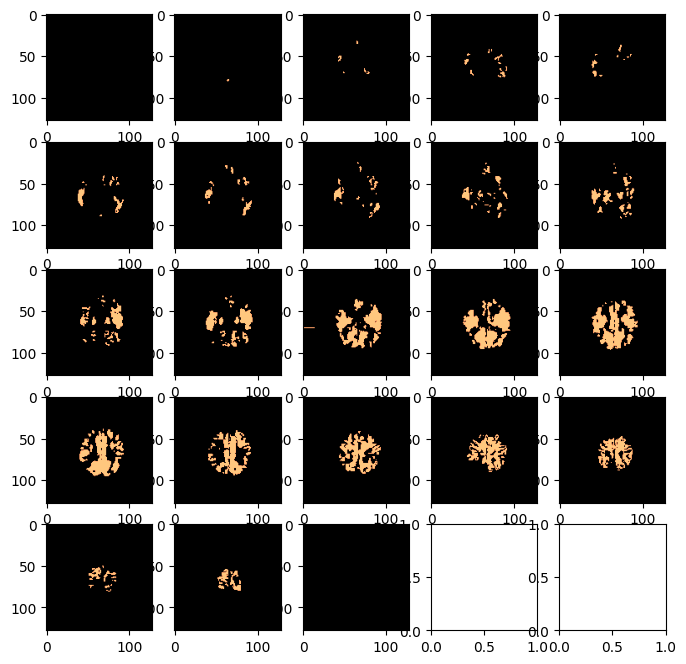

In [11]:
fig, axes = plt.subplots(5,5, figsize=(8,8))

for i,ax in enumerate(axes.flat):
    if i < label_data[0].shape[0]:
        ax.imshow(label_data[0][i], cmap="copper")

# **Data Augmentation**

In [12]:
# Flatten a list of data with n length and (m, 128, 128) shape of each array, so it becomes a list of n*m of arrays of shape (128, 128)

flattened_adc_data = [item for sublist in adc_data for item in sublist]
flattened_zadc_data = [item for sublist in zadc_data for item in sublist]
flattened_label_data = [item for sublist in label_data for item in sublist]

In [13]:
def slice_image(image):
    """
    Slices the given image into 128x128 patches.
    
    Args:
    image (numpy.ndarray): The image to be sliced, expected shape is (H, W).
    
    Returns:
    list: A list of 128x128 image patches.
    """
    patches = []
    h, w = image.shape
    
    if (h, w) == (256, 256):
        # Slicing 256x256 image into four non-overlapping 128x128 patches
        patches.append(image[0:128, 0:128])
        patches.append(image[0:128, 128:256])
        patches.append(image[128:256, 0:128])
        patches.append(image[128:256, 128:256])
    elif (h, w) == (160, 160):
        # Slicing 160x160 image with overlap to create 128x128 patches
        patches.append(image[0:128, 0:128])
        patches.append(image[0:128, 32:160])
        patches.append(image[32:160, 0:128])
        patches.append(image[32:160, 32:160])
    elif (h, w) == (128, 128):
        # Returning the image itself if it's already 128x128
        patches.append(image)
    else:
        raise ValueError("Unsupported image size. Expected (128, 128), (160, 160), or (256, 256).")
    
    return patches

def process_images_and_labels(images, labels):
    """
    Processes lists of images and labels, slicing each into 128x128 patches.
    
    Args:
    images (list): List of numpy.ndarray images.
    labels (list): List of numpy.ndarray labels corresponding to the images.
    
    Returns:
    tuple: Two lists containing the sliced images and corresponding labels.
    """
    all_image_patches = []
    all_label_patches = []
    
    for image, label in zip(images, labels):
        image_patches = slice_image(image)
        label_patches = slice_image(label)
        
        all_image_patches.extend(image_patches)
        all_label_patches.extend(label_patches)
    
    return all_image_patches, all_label_patches

In [14]:
flattened_cropped_zadc_data_list, flattened_cropped_label_data_list = process_images_and_labels(flattened_adc_data, flattened_label_data)

In [15]:
# Convert the list of arrays to a single NumPy array
flattened_cropped_zadc_data = np.array(flattened_cropped_zadc_data_list)

# Reshape the array to have shape (num_samples, 128, 128, 1)
flattened_cropped_zadc_data = flattened_cropped_zadc_data.reshape((len(flattened_cropped_zadc_data_list), 128, 128, 1))

# Print the shape to verify
print(flattened_cropped_zadc_data.shape)

# If you also have label data in the same format

flattened_cropped_label_data = np.array(flattened_cropped_label_data_list)
flattened_cropped_label_data = flattened_cropped_label_data.reshape((len(flattened_cropped_label_data_list), 128, 128, 1))

# Print the shape to verify
print(flattened_cropped_label_data.shape)

(7829, 128, 128, 1)
(7829, 128, 128, 1)


# **U Net**

In [16]:
def unet_model(input_size=(128, 128, 1), num_classes=1):
    inputs = Input(input_size)

    # Encoder
    c1 = Conv2D(64, (3, 3), activation='relu', padding='same')(inputs)
    c1 = BatchNormalization()(c1)
    c1 = Conv2D(64, (3, 3), activation='relu', padding='same')(c1)
    c1 = BatchNormalization()(c1)
    p1 = MaxPooling2D((2, 2))(c1)

    c2 = Conv2D(128, (3, 3), activation='relu', padding='same')(p1)
    c2 = BatchNormalization()(c2)
    c2 = Conv2D(128, (3, 3), activation='relu', padding='same')(c2)
    c2 = BatchNormalization()(c2)
    p2 = MaxPooling2D((2, 2))(c2)

    c3 = Conv2D(256, (3, 3), activation='relu', padding='same')(p2)
    c3 = BatchNormalization()(c3)
    c3 = Conv2D(256, (3, 3), activation='relu', padding='same')(c3)
    c3 = BatchNormalization()(c3)
    p3 = MaxPooling2D((2, 2))(c3)

    c4 = Conv2D(512, (3, 3), activation='relu', padding='same')(p3)
    c4 = BatchNormalization()(c4)
    c4 = Conv2D(512, (3, 3), activation='relu', padding='same')(c4)
    c4 = BatchNormalization()(c4)
    p4 = MaxPooling2D((2, 2))(c4)

    # Bottleneck
    c5 = Conv2D(1024, (3, 3), activation='relu', padding='same')(p4)
    c5 = BatchNormalization()(c5)
    c5 = Conv2D(1024, (3, 3), activation='relu', padding='same')(c5)
    c5 = BatchNormalization()(c5)

    # Decoder
    u6 = UpSampling2D((2, 2))(c5)
    u6 = concatenate([u6, c4])
    c6 = Conv2D(512, (3, 3), activation='relu', padding='same')(u6)
    c6 = BatchNormalization()(c6)
    c6 = Conv2D(512, (3, 3), activation='relu', padding='same')(c6)
    c6 = BatchNormalization()(c6)

    u7 = UpSampling2D((2, 2))(c6)
    u7 = concatenate([u7, c3])
    c7 = Conv2D(256, (3, 3), activation='relu', padding='same')(u7)
    c7 = BatchNormalization()(c7)
    c7 = Conv2D(256, (3, 3), activation='relu', padding='same')(c7)
    c7 = BatchNormalization()(c7)

    u8 = UpSampling2D((2, 2))(c7)
    u8 = concatenate([u8, c2])
    c8 = Conv2D(128, (3, 3), activation='relu', padding='same')(u8)
    c8 = BatchNormalization()(c8)
    c8 = Conv2D(128, (3, 3), activation='relu', padding='same')(c8)
    c8 = BatchNormalization()(c8)

    u9 = UpSampling2D((2, 2))(c8)
    u9 = concatenate([u9, c1])
    c9 = Conv2D(64, (3, 3), activation='relu', padding='same')(u9)
    c9 = BatchNormalization()(c9)
    c9 = Conv2D(64, (3, 3), activation='relu', padding='same')(c9)
    c9 = BatchNormalization()(c9)

    outputs = Conv2D(num_classes, (1, 1), activation='sigmoid' if num_classes == 1 else 'softmax')(c9)

    model = Model(inputs=[inputs], outputs=[outputs])
    return model

In [17]:
def dice_loss(y_true, y_pred):
    smooth = 1e-6
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return 1 - (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)

In [18]:
# Define paths
checkpoint_dir = '/UNet'
checkpoint_filepath = os.path.join(checkpoint_dir, 'model_checkpoint_{epoch:02d}.keras')
if not os.path.exists(checkpoint_dir):
    os.makedirs(checkpoint_dir)
latest_checkpoint = max([os.path.join(checkpoint_dir, f) for f in os.listdir(checkpoint_dir) if f.startswith('model_checkpoint')], key=os.path.getctime, default=None)
csv_logger_path = 'training_log.csv'

# Create the CSVLogger
csv_logger = CSVLogger(csv_logger_path, append=True)

# ModelCheckpoint callback to save the model
model_checkpoint_callback = ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=False,
    monitor='val_mean_io_u',
    mode='max',
    save_best_only=False,
    save_freq='epoch'
)

In [19]:
# Compile the model
model = unet_model()
model.compile(optimizer=SGD(learning_rate=1e-4), loss=dice_loss, metrics=['accuracy', MeanIoU(num_classes=2)])

# Load model from the last checkpoint if it exists
if latest_checkpoint is not None:
    model = load_model(latest_checkpoint, custom_objects={'dice_loss': dice_loss, 'MeanIoU': MeanIoU})
    print(f"Loaded model from {latest_checkpoint}")

# Summary of the model
model.summary()

Loaded model from /UNet\model_checkpoint_100.keras
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 128, 128, 1  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 128, 128, 64  640         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 128, 128, 64  256        ['conv2d[0][0]']                 
 alization)                     )          

In [20]:
# Split the data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(flattened_cropped_zadc_data, flattened_cropped_label_data, test_size=0.2, random_state=42)

# Fit the model with validation data
history = model.fit(X_train, y_train, epochs=200, batch_size=16, validation_data=(X_val, y_val), callbacks=[model_checkpoint_callback, csv_logger])

Epoch 1/200
392/392 [==============================] - 222s 509ms/step - loss: 0.9720 - accuracy: 0.8185 - mean_io_u: 0.4920 - val_loss: 0.9610 - val_accuracy: 0.8262 - val_mean_io_u: 0.4909
Epoch 2/200
392/392 [==============================] - 186s 473ms/step - loss: 0.9653 - accuracy: 0.8163 - mean_io_u: 0.4920 - val_loss: 0.9526 - val_accuracy: 0.8210 - val_mean_io_u: 0.4909
Epoch 3/200
392/392 [==============================] - 185s 473ms/step - loss: 0.9585 - accuracy: 0.8134 - mean_io_u: 0.4921 - val_loss: 0.9452 - val_accuracy: 0.8199 - val_mean_io_u: 0.4910
Epoch 4/200
392/392 [==============================] - 185s 473ms/step - loss: 0.9539 - accuracy: 0.8151 - mean_io_u: 0.4923 - val_loss: 0.9419 - val_accuracy: 0.8219 - val_mean_io_u: 0.4910
Epoch 5/200
392/392 [==============================] - 185s 473ms/step - loss: 0.9512 - accuracy: 0.8195 - mean_io_u: 0.4924 - val_loss: 0.9390 - val_accuracy: 0.8279 - val_mean_io_u: 0.4913
Epoch 6/200
392/392 [========================

In [26]:
import pandas as pd
# Load the training history from CSV
history_df = pd.read_csv(csv_logger_path)

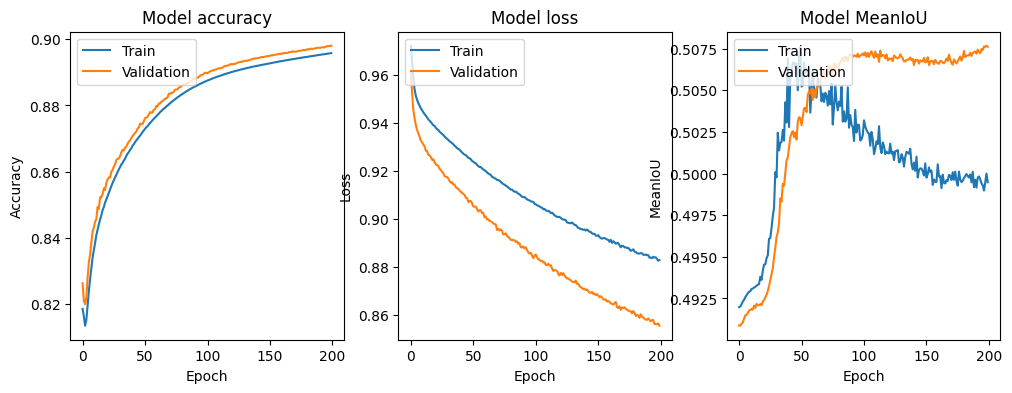

In [24]:
# Plot training & validation accuracy, loss, and MeanIoU values
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 4))
plt.subplot(1, 3, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.subplot(1, 3, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.subplot(1, 3, 3)
plt.plot(history.history['mean_io_u'])
plt.plot(history.history['val_mean_io_u'])
plt.title('Model MeanIoU')
plt.ylabel('MeanIoU')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.show()

1/1 [==============================] - 2s 2s/step


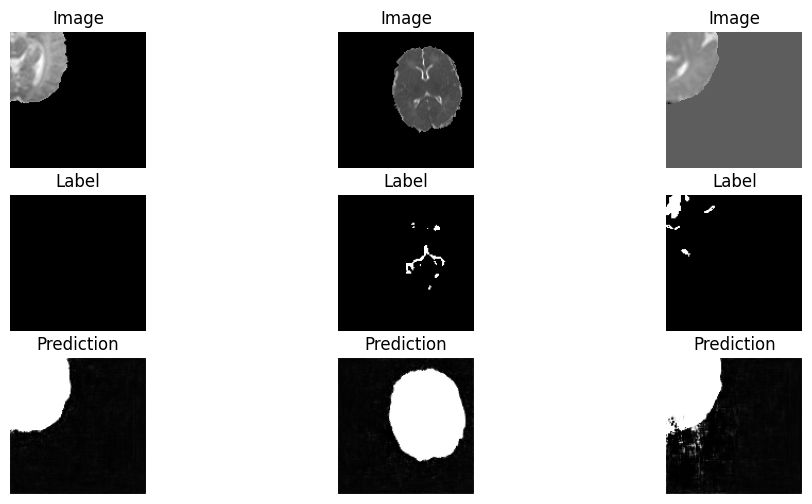

In [25]:
images = X_val[10:13]
labels = y_val[10:13]

# Get model predictions on a few samples
predictions = model.predict(images)

# Visualize the predictions
def visualize_predictions(images, labels, predictions, num_samples=3):
    plt.figure(figsize=(12, 6))
    for i in range(num_samples):
        plt.subplot(3, num_samples, i + 1)
        plt.imshow(images[i].reshape(128, 128), cmap='gray')
        plt.title('Image')
        plt.axis('off')

        plt.subplot(3, num_samples, i + 1 + num_samples)
        plt.imshow(labels[i].reshape(128, 128), cmap='gray')
        plt.title('Label')
        plt.axis('off')

        plt.subplot(3, num_samples, i + 1 + 2*num_samples)
        plt.imshow(predictions[i].reshape(128, 128), cmap='gray')
        plt.title('Prediction')
        plt.axis('off')
    plt.show()

visualize_predictions(images, labels, predictions)
